In [147]:
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import time

%matplotlib inline
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

warnings.filterwarnings("ignore") # specify to ignore warning messages

In [148]:
df = pd.read_csv('Apartment_List_Rent_Estimates_CBSA_2021_6.csv')
print("Original Shape:", df.shape)

df = df.dropna()
cities_na = [ 'Amarillo, TX' 
             ,'Greenville, NC' 
             ,'Hilton Head Island-Bluffton, SC'
             ,'Mobile, AL'
             ,'Myrtle Beach-Conway-North Myrtle Beach, SC-NC'
             ,'Stockton, CA'
             ,'Williston, ND'
            ]
df = df[~df['CBSA_Name'].isin(cities_na)]
print("Updated Shape - Remove NAs:", df.shape)
df.head()

Original Shape: (1098, 58)
Updated Shape - Remove NAs: (1044, 58)


,CBSA_Name,FIPS_Code,Population,Bedroom_Size,2017_01,2017_02,2017_03,2017_04,2017_05,2017_06,2017_07,2017_08,2017_09,2017_10,2017_11,2017_12,2018_01,2018_02,2018_03,2018_04,2018_05,2018_06,2018_07,2018_08,2018_09,2018_10,2018_11,2018_12,2019_01,2019_02,2019_03,2019_04,2019_05,2019_06,2019_07,2019_08,2019_09,2019_10,2019_11,2019_12,2020_01,2020_02,2020_03,2020_04,2020_05,2020_06,2020_07,2020_08,2020_09,2020_10,2020_11,2020_12,2021_01,2021_02,2021_03,2021_04,2021_05,2021_06
0,"Abilene, TX",10180.0,170009.0,_Overall,978.00,982.00,1018.00,1041.00,1020.00,1015.00,994.00,988.00,973.00,998.00,1005.00,995.00,982.00,961.00,984.00,964.00,977.00,974.00,988.00,989.00,974.00,977.00,980.00,993.00,992.00,1001.00,1017.00,1041.00,1066.00,1080.00,1092.00,1093.00,1085.00,1070.00,1059.00,1058.00,1066.00,1069.00,1105.00,1107.00,1110.00,1086.00,1096.00,1108.00,1119.00,1122.00,1119.00,1113.00,1120.00,1124.00,1132.00,1132.00,1141.00,1151.00
1,"Abilene, TX",10180.0,170009.0,_Studio,718.00,720.00,747.00,764.00,748.00,744.00,729.00,725.00,713.00,732.00,737.00,730.00,720.00,705.00,722.00,707.00,716.00,714.00,725.00,725.00,715.00,717.00,719.00,728.00,728.00,734.00,746.00,764.00,782.00,792.00,801.00,802.00,796.00,785.00,777.00,776.00,782.00,784.00,810.00,812.00,814.00,797.00,804.00,813.00,821.00,823.00,820.00,816.00,821.00,825.00,831.00,831.00,837.00,844.00
2,"Abilene, TX",10180.0,170009.0,1br,715.00,718.00,745.00,762.00,746.00,742.00,727.00,722.00,711.00,730.00,735.00,727.00,718.00,703.00,719.00,705.00,714.00,712.00,723.00,723.00,713.00,715.00,717.00,726.00,725.00,732.00,744.00,761.00,780.00,790.00,799.00,799.00,793.00,782.00,774.00,773.00,780.00,782.00,808.00,810.00,812.00,794.00,801.00,810.00,818.00,821.00,818.00,814.00,819.00,822.00,828.00,828.00,834.00,842.00
3,"Abilene, TX",10180.0,170009.0,2br,922.00,926.00,960.00,982.00,961.00,957.00,937.00,931.00,917.00,941.00,948.00,938.00,926.00,906.00,928.00,909.00,921.00,918.00,932.00,932.00,919.00,921.00,924.00,936.00,935.00,944.00,959.00,981.00,1005.00,1019.00,1030.00,1031.00,1023.00,1009.00,998.00,997.00,1005.00,1008.00,1042.00,1044.00,1047.00,1024.00,1033.00,1045.00,1055.00,1058.00,1055.00,1049.00,1056.00,1060.00,1068.00,1068.00,1076.00,1085.00
4,"Abilene, TX",10180.0,170009.0,3br,1173.00,1177.00,1221.00,1249.00,1223.00,1217.00,1192.00,1185.00,1166.00,1197.00,1206.00,1193.00,1178.00,1153.00,1180.00,1156.00,1171.00,1168.00,1185.00,1186.00,1169.00,1172.00,1175.00,1190.00,1190.00,1201.00,1220.00,1248.00,1278.00,1296.00,1310.00,1311.00,1301.00,1283.00,1270.00,1269.00,1279.00,1283.00,1325.00,1328.00,1332.00,1303.00,1314.00,1329.00,1342.00,1346.00,1342.00,1335.00,1343.00,1349.00,1358.00,1358.00,1368.00,1381.00


### Going to reshape the data

In [159]:
# change parameters here
city_name = 'Los Angeles-Long Beach-Anaheim, CA'
bdrm = '_Overall'


record = df.loc[(df['CBSA_Name']== city_name) & (df['Bedroom_Size'] == bdrm)]



record = record.T
rename = record.columns[0]
record = record.rename(columns={rename:'avg_rent'}) 
record = record.iloc[4:]
record['avg_rent'] = record['avg_rent'].astype(float)
record.reset_index(inplace = True)
record.rename(columns = {'index':'month_year'}, inplace = True)

# here's a block to change the date string to end of the month datetime
record['year'] = [x[0:4] for x in record['month_year']]
record['month'] = [x[-2:] for x in record['month_year']]
record['month_end'] = record['year']+ '-' + record['month']+ '-' + '01'
record['month_end'] = pd.to_datetime(record['month_end'])
record.set_index('month_end', inplace = True)
record.index = record.index.to_period('M').to_timestamp('M')
record.drop(['month_year', 'year', 'month'], axis = 1, inplace = True)
#record.reset_index(inplace = True)

# define a y variable to pass to arima model
y = record['avg_rent'].values

record.head()

,avg_rent
month_end,
2017-01-31,1816.0
2017-02-28,1831.0
2017-03-31,1842.0
2017-04-30,1836.0
2017-05-31,1836.0


In [ ]:
# and here we have our array
y

<AxesSubplot:xlabel='month_end'>

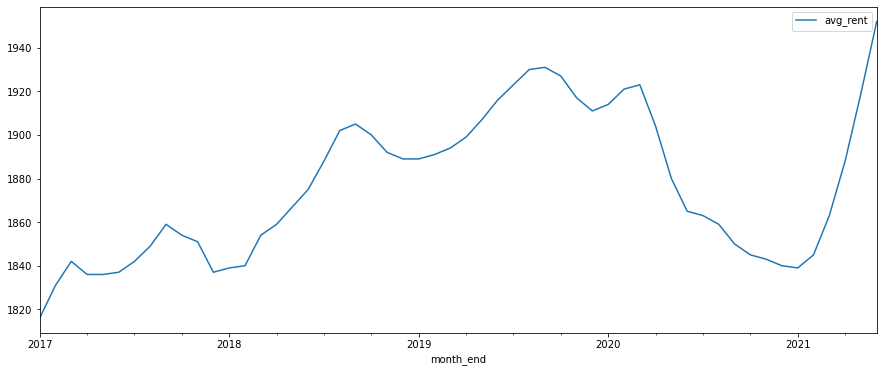

In [160]:
record.plot(figsize=(15, 6))

# price dips near beginning of the year? 

## Model Selection

In [150]:
#### Parameter Descriptions:
# p is the auto-regressive part of the model
    # allows us to incorporate the effect of past values into our model
    # similar to stating that it is likely to be warm tomorrow if it has been warm the past 3 days
# d is the integrated part of the model
    # includes terms in the model that incorporate the amount of differencing to apply to the time series
    # similar to stating that it is likely to be same temperature tomorrow if the difference in temperature in the last three days has been very small
# q is the moving average part of the model
    # allows us to set the error of our model as a linear combination of the error values observed at previous time points in the past

# Use a “grid search” to iteratively explore different combinations of parameters
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

# use parameter triplets to automate the process of training and evaluating ARIMA models on different combinations

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [ ]:
# fit data on all parameter triplets to get AIC (goodness-of-fit with complexity consideration)

results_list = []
param_list = []
seasonal_param_list = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        param_list.append(param)
        seasonal_param_list.append(param_seasonal)
        try:
            mod = sm.tsa.statespace.SARIMAX(record,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()
            results_list.append(results.aic)
            #print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

In [ ]:
results_df = pd.DataFrame({'param':param_list
              , 'seasonal_param':seasonal_param_list
              , 'aic':results_list})
min_aic = results_df['aic'].min()
print(min_aic)

results_df.head()

In [ ]:
# optimal option out of all the models considered
final_param = results_df.loc[results_df['aic'] == min_aic]['param'].values[0]
final_seasonal = results_df.loc[results_df['aic'] == min_aic]['seasonal_param'].values[0]


results_df.loc[results_df['aic'] == min_aic]

## Fit Final ARIMA Time Series Model

In [ ]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=final_param,
                                seasonal_order=final_seasonal,
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

# first two features have "significant" p-values (< or ~ 0.05)

In [ ]:
# run model diagnostics to ensure that none of the assumptions made by the model have been violated
results.plot_diagnostics(figsize=(15, 12))

plt.show() # add this line to avoid double plots



# histogram (top right)
    # we see that the orange KDE line follows closely with the standard normal N(0,1) line 
    # good indication that the residuals are normally distributed
# qq-plot (bottom left)
    # shows ordered distribution of residuals follow the linear samples taken from a standard normal distribution 
    # strong indication that the residuals are normally distributed
    

# residuals over time (top left) 
    # does not display any obvious seasonality and appears to be white noise
    # DOES THIS LOOK A PATTERN?????????
#  autocorrelation (bottom right)
    # time series residuals have low correlation with lagged versions of itself
    # < 0.5 correlations but > 0.25, is too much????????
    

### Validating Forecasts

#### Static Forecast

In [ ]:
# produce one-step ahead forecasts, (forecasts generated using the full history)
pred = results.get_prediction(dynamic=False) 
pred_ci = pred.conf_int()


In [ ]:
y_forecasted = pred.predicted_mean

# Compute the mean square error
mse = ((y_forecasted - y) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

In [ ]:
print(y)

print(y_forecasted)

print(pred_ci[:10])

In [ ]:
# add forecasted rent and the confidence interval to record dataframe for graph purposes
record['forecasted_rent'] = y_forecasted
record['CI_low'] = pred_ci[:, 0]
record['CI_high'] = pred_ci[:, 1]


In [ ]:
ax = record['avg_rent'].plot(label='Observed Average Rent', color = '#f26835', figsize=(15, 6))
record['forecasted_rent']['2020':].plot(ax=ax, label='Forecasted Rent', alpha=.4, color = "#7d9ea2")

ax.fill_between(record.index[-len(record['forecasted_rent']['2020':]):],
                pd.DataFrame.to_numpy(record['CI_low']['2020':]),
                pd.DataFrame.to_numpy(record['CI_high']['2020':]), 
                color='k', alpha=.05)

ax.set_xlabel('Date', fontsize=20)
ax.set_ylabel('Rent Prices', fontsize=20)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(loc = 'upper left',prop={'size': 15})
plt.title("Overall", fontsize=20)
plt.savefig(str("presentation_plots/LA/Overall_Model.png"))                                       
plt.show()

## Produce and Visualize Forecast

In [ ]:
# Get forecast several steps ahead in future
steps = 42
pred_uc = results.get_forecast(steps=steps)
predictions = pred_uc.predicted_mean

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()
CI_low = pred_ci[:, 0]
CI_high = pred_ci[:, 1]

#create DatetimeIndex by last value of index and remove first value by indexing
idx = pd.date_range(record.index[-1], periods=steps+1, freq='1m')[1:]

#append to original
future_predictions = pd.DataFrame(predictions, columns = ["forecasted_rent"], index=idx)
future_predictions['CI_low'] = CI_low
future_predictions['CI_high'] = CI_high
record_predictions = record.append(future_predictions)
record_predictions

In [ ]:
ax = record_predictions['avg_rent'].plot(label='Observed Average Rent', figsize=(20, 15), color = '#f26835')
record_predictions['forecasted_rent']['2020':].plot(ax=ax, label='Forecasted Rent', alpha=.4, color = "#7d9ea2")

ax.fill_between(record_predictions.index[-len(record_predictions['forecasted_rent']['2020':]):],
                pd.DataFrame.to_numpy(record_predictions['CI_low']['2020':]),
                pd.DataFrame.to_numpy(record_predictions['CI_high']['2020':]), 
                color='k', alpha=.05)

ax.set_xlabel('Date', fontsize=20)
ax.set_ylabel('Rent Prices', fontsize=20)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(loc = 'upper left',prop={'size': 20})
plt.title("Overall", fontsize=20)
plt.savefig(str("presentation_plots/LA/Overall_Forecast.png"))   
plt.show()

#### Dynamic Forecast

Not nearly as good at future predictions as static forecasting because it does not know how to handle COVID. 

In [ ]:
# forecasts are generated using values from previous forecasted time points
pred_dynamic = results.get_prediction(start= len(record['forecasted_rent']['2020':])
                                      , dynamic=True
                                      , full_results = True) 

pred_ci_dynamic = pred_dynamic.conf_int()

In [ ]:
y_forecasted_dynamic = pred_dynamic.predicted_mean
y_forecasted_dynamic 
mse_dynamic = ((y_forecasted_dynamic - y[-len(record['forecasted_rent']['2020':])]) ** 2).mean()
print('The Mean Squared Error of our dynamic forecasts is {}'.format(round(mse_dynamic, 2)))

#### Note: Dynamic Forecasting has worse MSE ####

In [ ]:
print(y)

print(y_forecasted_dynamic)

print(pred_ci_dynamic[:10])

In [ ]:
index = [i for i in range(len(record['forecasted_rent']['2020':]))]

record_dynamic = record.drop(record.index[index])

record_dynamic['forecasted_rent'] = y_forecasted_dynamic
record_dynamic['CI_low'] = pred_ci_dynamic[:, 0]
record_dynamic['CI_high'] = pred_ci_dynamic[:, 1]

record_dynamic.shape

In [ ]:
ax = record['avg_rent'].plot(label='Observed Average Rent', color = 'orange', figsize=(15, 6))
record_dynamic['forecasted_rent']['2020':].plot(ax=ax, label='Forecasted Rent (Dynamic)', alpha=.4, color = "green")

ax.set_xlabel('Date')
ax.set_ylabel('Rent Prices')
plt.legend(loc = 'upper left')
plt.title("Dynamic Forecast")

plt.show()

In [ ]:
ax = record['avg_rent'].plot(label='Observed Average Rent', color = 'orange', figsize=(15, 6))
record_dynamic['forecasted_rent']['2020':].plot(ax=ax, label='Forecasted Rent (Dynamic)', alpha=.4, color = "green")

ax.fill_between(record_dynamic.index[-len(record_dynamic['forecasted_rent']['2020':]):],
                pd.DataFrame.to_numpy(record_dynamic['CI_low']['2020':]),
                pd.DataFrame.to_numpy(record_dynamic['CI_high']['2020':]), 
                color='k', alpha=.05)

ax.set_xlabel('Date')
ax.set_ylabel('Rent Prices')
plt.legend(loc = 'upper left')
plt.title("Dynamic Forecast with Confidence Interval")

plt.show()

# All unique city bedroom combinations

### Create a dictionary of all unique combinations' dataframes

In [308]:
cities = df['CBSA_Name'].unique() # 174 unique cities
bedrooms = df['Bedroom_Size'].unique() # 6 unique bedroom types

record_names = []
record_dictionary = {}

for i in range(0,len(cities)):
    
    for j in range(0,len(bedrooms)):
        
        # create record name, concatonate city and bedroom type
        record_name = str(cities[i] + bedrooms[j])
        record_name = record_name.replace('/', '-')
        record_names.append(record_name)
        
        record = df.loc[(df['CBSA_Name']== cities[i]) & (df['Bedroom_Size'] == bedrooms[j])]
        record = record.T
        rename = record.columns[0]
        record = record.rename(columns={rename:'avg_rent'}) 
        record = record.iloc[4:]
        record['avg_rent'] = record['avg_rent'].astype(float)
        record.reset_index(inplace = True)
        record.rename(columns = {'index':'month_year'}, inplace = True)

        # here's a block to change the date string to end of the month datetime
        record['year'] = [x[0:4] for x in record['month_year']]
        record['month'] = [x[-2:] for x in record['month_year']]
        record['month_end'] = record['year']+ '-' + record['month']+ '-' + '01'
        record['month_end'] = pd.to_datetime(record['month_end'])
        record.set_index('month_end', inplace = True)
        record.index = record.index.to_period('M').to_timestamp('M')
        record.drop(['month_year', 'year', 'month'], axis = 1, inplace = True)
        #record.reset_index(inplace = True)

        # define a y variable to pass to arima model
        y = record['avg_rent'].values
        
        record_dictionary[record_name] = record
    

### Determine Optimal Model for each Dataframe and Save Forecast

This code chunk takes approximately 90 minutes to run so all model/forecast graphs are saved as .png in the **plots** folder and all the AIC and MSE of the resulting optimal models are stored in **record_model_info.csv**

In [ ]:
start_time = time.time()

# create dataframe to store the AIC of each optimal model as well as the MSE
record_model_info = pd.DataFrame(columns = ['name','min_AIC','MSE'])


for i in range(len(record_names)):
    
    record = record_dictionary[record_names[i]]
    
    # grid search for parameters

    results_list = []
    param_list = []
    seasonal_param_list = []

    for param in pdq:
        for param_seasonal in seasonal_pdq:
            param_list.append(param)
            seasonal_param_list.append(param_seasonal)
            try:
                mod = sm.tsa.statespace.SARIMAX(record,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                results = mod.fit()
                results_list.append(results.aic)
            except:
                continue
    
    # determine optimal model
    
    results_df = pd.DataFrame({'param':param_list
              , 'seasonal_param':seasonal_param_list
              , 'aic':results_list})
    min_aic = results_df['aic'].min()
    print(record_names[i]," min AIC:", min_aic)
    
    final_param = results_df.loc[results_df['aic'] == min_aic]['param'].values[0]
    final_seasonal = results_df.loc[results_df['aic'] == min_aic]['seasonal_param'].values[0]
    
    # array for ARIMA model
    y = record['avg_rent'].values
    
    
    mod = sm.tsa.statespace.SARIMAX(y
                                    ,order=final_param
                                    ,seasonal_order=final_seasonal
                                    ,enforce_stationarity=False
                                    ,enforce_invertibility=False
                                   )
    results = mod.fit()
    
    
    # make predictions
    pred = results.get_prediction(dynamic=False) 
    pred_ci = pred.conf_int()
    y_forecasted = pred.predicted_mean

    # Compute the mean square error
    mse = ((y_forecasted - y) ** 2).mean()
    print(record_names[i],'MSE: {}'.format(round(mse, 2)))
    
    
    # add forecasted rent and the confidence interval to record dataframe for graph purposes
    record['forecasted_rent'] = y_forecasted
    record['CI_low'] = pred_ci[:, 0]
    record['CI_high'] = pred_ci[:, 1]

    plt.clf()
    ax = record['avg_rent'].plot(label='Observed Average Rent', color = 'orange', figsize=(15, 6))
    record['forecasted_rent']['2020':].plot(ax=ax, label='Forecasted Rent (Static)', alpha=.4, color = "green")

    ax.fill_between(record.index[-len(record['forecasted_rent']['2020':]):],
                    pd.DataFrame.to_numpy(record['CI_low']['2020':]),
                    pd.DataFrame.to_numpy(record['CI_high']['2020':]), 
                    color='k', alpha=.05
                   )

    ax.set_xlabel('Date')
    ax.set_ylabel('Rent Prices')
    plt.legend(loc = 'upper left')
    plt.title(str("Static Model for " + record_names[i]))

    plt.savefig(str("plots/" + record_names[i] + "_Model.png"))
    
    # Get forecast several steps ahead in future
    steps = 42
    pred_uc = results.get_forecast(steps=steps)
    predictions = pred_uc.predicted_mean

    # Get confidence intervals of forecasts
    pred_ci = pred_uc.conf_int()
    CI_low = pred_ci[:, 0]
    CI_high = pred_ci[:, 1]

    #create DatetimeIndex by last value of index and remove first value by indexing
    idx = pd.date_range(record.index[-1], periods=steps+1, freq='1m')[1:]

    #append to original
    future_predictions = pd.DataFrame(predictions, columns = ["forecasted_rent"], index=idx)
    future_predictions['CI_low'] = CI_low
    future_predictions['CI_high'] = CI_high
    record_predictions = record.append(future_predictions)

    plt.clf()
    ax = record_predictions['avg_rent'].plot(label='observed', figsize=(20, 15))
    record_predictions['forecasted_rent']['2020':].plot(ax=ax, label='Forecasted Rent (Static)', alpha=.4, color = "green")

    ax.fill_between(record_predictions.index[-len(record_predictions['forecasted_rent']['2020':]):],
                    pd.DataFrame.to_numpy(record_predictions['CI_low']['2020':]),
                    pd.DataFrame.to_numpy(record_predictions['CI_high']['2020':]), 
                    color='k', alpha=.05)

    ax.set_xlabel('Date')
    ax.set_ylabel('Rent Prices')
    plt.legend(loc = 'upper left')
    plt.title(str("Static Forecast (End of 2025) for " + record_names[i]))
    plt.legend(loc = 'upper left')
    plt.savefig(str("plots/" + record_names[i] + "_Forecast.png"))
    plt.close()
    
    new_model_info = pd.DataFrame({'name':[record_names[i]], 'min_AIC': [min_aic], 'MSE': [mse]})
    record_model_info = record_model_info.append(new_model_info)
    

print("This loop took", (time.time() - start_time)/60 , "minutes to run") 

record_model_info.to_csv('record_model_info.csv', index=False) # save min AIC and MSE for each combo

print("The plots and model information have been saved successfully!")

In [ ]:
record_model_info = pd.read_csv("record_model_info.csv")
record_model_infos

In [ ]:
record_model_info.describe()

## City with All Bedroom Types

In [358]:
NAMES = df['CBSA_Name'].unique()

  
# printing original list 
# print ("The original list is : " + str(NAMES ))
  
# initializing substring
subs = 'TX'
  
# using filter() + lambda 
# to get string with substring 
res = list(filter(lambda x: subs in x, NAMES ))
  
# printing result 
print ("All strings with given substring are : " + str(res))

NAMES

All strings with given substring are : ['Abilene, TX', 'Austin-Round Rock-Georgetown, TX', 'College Station-Bryan, TX', 'Corpus Christi, TX', 'Dallas-Fort Worth-Arlington, TX', 'El Paso, TX', 'Houston-The Woodlands-Sugar Land, TX', 'Killeen-Temple, TX', 'Lubbock, TX', 'Midland, TX', 'Odessa, TX', 'San Antonio-New Braunfels, TX', 'Tyler, TX', 'Waco, TX']


array(['Abilene, TX', 'Akron, OH', 'Albany-Schenectady-Troy, NY',
       'Albuquerque, NM', 'Allentown-Bethlehem-Easton, PA-NJ', 'Ames, IA',
       'Anchorage, AK', 'Ann Arbor, MI', 'Asheville, NC',
       'Athens-Clarke County, GA', 'Atlanta-Sandy Springs-Alpharetta, GA',
       'Augusta-Richmond County, GA-SC',
       'Austin-Round Rock-Georgetown, TX', 'Bakersfield, CA',
       'Baltimore-Columbia-Towson, MD', 'Baton Rouge, LA',
       'Bellingham, WA', 'Bend, OR', 'Birmingham-Hoover, AL',
       'Bismarck, ND', 'Boise City, ID', 'Boston-Cambridge-Newton, MA-NH',
       'Boulder, CO', 'Bremerton-Silverdale-Port Orchard, WA',
       'Bridgeport-Stamford-Norwalk, CT', 'Cape Coral-Fort Myers, FL',
       'Cedar Rapids, IA', 'Charleston-North Charleston, SC',
       'Charlotte-Concord-Gastonia, NC-SC', 'Charlottesville, VA',
       'Chattanooga, TN-GA', 'Chicago-Naperville-Elgin, IL-IN-WI',
       'Chico, CA', 'Cincinnati, OH-KY-IN', 'Clarksville, TN-KY',
       'Cleveland-Elyria, OH', 

In [397]:
cities = [  'Austin-Round Rock-Georgetown, TX']
bedrooms = df['Bedroom_Size'].unique()

record_names = []
record_dictionary = {}

for i in range(0,len(cities)):
    
    for j in range(0,len(bedrooms)):
        
        # create record name, concatonate city and bedroom type
        record_name = str(bedrooms[j] + '_' + cities[i])
        record_name = record_name.replace('/', '-')
        record_names.append(record_name)
        
        record = df.loc[(df['CBSA_Name']== cities[i]) & (df['Bedroom_Size'] == bedrooms[j])]
        record = record.T
        rename = record.columns[0]
        record = record.rename(columns={rename:'avg_rent'}) 
        record = record.iloc[4:]
        record['avg_rent'] = record['avg_rent'].astype(float)
        record.reset_index(inplace = True)
        record.rename(columns = {'index':'month_year'}, inplace = True)

        # here's a block to change the date string to end of the month datetime
        record['year'] = [x[0:4] for x in record['month_year']]
        record['month'] = [x[-2:] for x in record['month_year']]
        record['month_end'] = record['year']+ '-' + record['month']+ '-' + '01'
        record['month_end'] = pd.to_datetime(record['month_end'])
        record.set_index('month_end', inplace = True)
        record.index = record.index.to_period('M').to_timestamp('M')
        record.drop(['month_year', 'year', 'month'], axis = 1, inplace = True)
        #record.reset_index(inplace = True)

        # define a y variable to pass to arima model
        y = record['avg_rent'].values
        
        record_dictionary[record_name] = record

record_names

['_Overall_Austin-Round Rock-Georgetown, TX',
 '_Studio_Austin-Round Rock-Georgetown, TX',
 '1br_Austin-Round Rock-Georgetown, TX',
 '2br_Austin-Round Rock-Georgetown, TX',
 '3br_Austin-Round Rock-Georgetown, TX',
 '4br_Austin-Round Rock-Georgetown, TX']

_Overall_Austin-Round Rock-Georgetown, TX  min AIC: 176.9696259542038
_Overall_Austin-Round Rock-Georgetown, TX MSE: 50139.58
_Studio_Austin-Round Rock-Georgetown, TX  min AIC: 169.41422207410673
_Studio_Austin-Round Rock-Georgetown, TX MSE: 29153.17
1br_Austin-Round Rock-Georgetown, TX  min AIC: 173.92725882334366
1br_Austin-Round Rock-Georgetown, TX MSE: 38278.46
2br_Austin-Round Rock-Georgetown, TX  min AIC: 177.44561216936577
2br_Austin-Round Rock-Georgetown, TX MSE: 54289.21
3br_Austin-Round Rock-Georgetown, TX  min AIC: 190.26563305846818
3br_Austin-Round Rock-Georgetown, TX MSE: 78961.16
4br_Austin-Round Rock-Georgetown, TX  min AIC: 198.68756535940267
4br_Austin-Round Rock-Georgetown, TX MSE: 108321.96
This loop took 0.43128006855646767 minutes to run
The plots and model information have been saved successfully!
(54, 24)


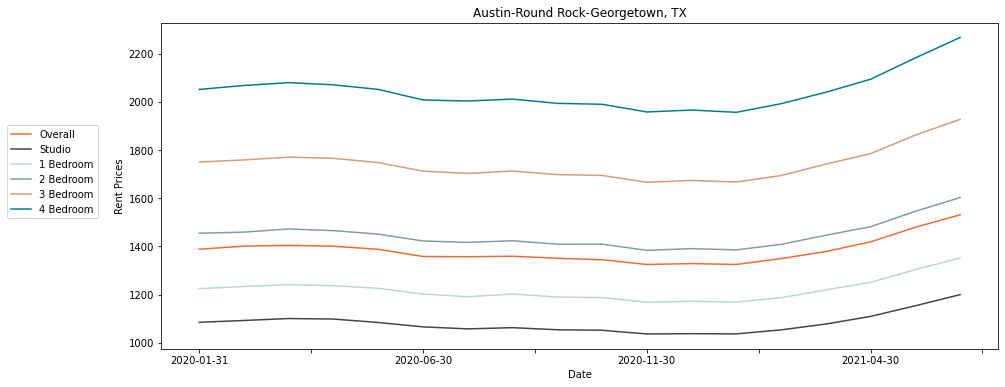

In [398]:
start_time = time.time()


for i in range(len(record_names)):
    
    record = record_dictionary[record_names[i]]
    
    # grid search for parameters

    results_list = []
    param_list = []
    seasonal_param_list = []

    for param in pdq:
        for param_seasonal in seasonal_pdq:
            param_list.append(param)
            seasonal_param_list.append(param_seasonal)
            try:
                mod = sm.tsa.statespace.SARIMAX(record,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                results = mod.fit()
                results_list.append(results.aic)
            except:
                continue
    
    # determine optimal model
    
    results_df = pd.DataFrame({'param':param_list
              , 'seasonal_param':seasonal_param_list
              , 'aic':results_list})
    min_aic = results_df['aic'].min()
    print(record_names[i]," min AIC:", min_aic)
    
    final_param = results_df.loc[results_df['aic'] == min_aic]['param'].values[0]
    final_seasonal = results_df.loc[results_df['aic'] == min_aic]['seasonal_param'].values[0]
    
    # array for ARIMA model
    y = record['avg_rent'].values
    
    
    mod = sm.tsa.statespace.SARIMAX(y
                                    ,order=final_param
                                    ,seasonal_order=final_seasonal
                                    ,enforce_stationarity=False
                                    ,enforce_invertibility=False
                                   )
    results = mod.fit()
    
    
    # make predictions
    pred = results.get_prediction(dynamic=False) 
    pred_ci = pred.conf_int()
    y_forecasted = pred.predicted_mean

    # Compute the mean square error
    mse = ((y_forecasted - y) ** 2).mean()
    print(record_names[i],'MSE: {}'.format(round(mse, 2)))
    
    
    # add forecasted rent and the confidence interval to record dataframe for graph purposes
    y_name = str('y_' + str(i))
    forecasted_rent = str('forecasted_rent_' + str(i))
    CI_low = str('CI_low_' + str(i))
    CI_high = str('CI_high_' + str(i))
    
#     record[forecasted_rent] = y_forecasted
#     record[CI_low] = pred_ci[:, 0]
#     record[CI_high] = pred_ci[:, 1]
    
    
    new_df = pd.DataFrame(
        data={y_name:y,forecasted_rent:y_forecasted, CI_low:pred_ci[:, 0], CI_high:pred_ci[:, 1]}, 
        columns=[y_name,forecasted_rent,CI_low,CI_high],
    index = record.index)
    
    new_df.to_csv(str('data/df' + str(i) + '.csv'), index=True)
    





#     plt.clf()
#     ax = record['avg_rent'].plot(label='Observed Average Rent', color = 'orange', figsize=(15, 6))
#     record['forecasted_rent']['2020':].plot(ax=ax, label='Forecasted Rent (Static)', alpha=.4, color = "green")

#     ax.fill_between(record.index[-len(record['forecasted_rent']['2020':]):],
#                     pd.DataFrame.to_numpy(record['CI_low']['2020':]),
#                     pd.DataFrame.to_numpy(record['CI_high']['2020':]), 
#                     color='k', alpha=.05
#                    )

#     ax.set_xlabel('Date')
#     ax.set_ylabel('Rent Prices')
#     plt.legend(loc = 'upper left')
#     plt.title(str("Static Model for " + record_names[i]))

#     plt.savefig(str("presentation_plots/" + record_names[i] + "ALL.png"))
    
    # Get forecast several steps ahead in future
#     steps = 42
#     pred_uc = results.get_forecast(steps=steps)
#     predictions = pred_uc.predicted_mean

#     # Get confidence intervals of forecasts
#     pred_ci = pred_uc.conf_int()
#     CI_low = pred_ci[:, 0]
#     CI_high = pred_ci[:, 1]

#     #create DatetimeIndex by last value of index and remove first value by indexing
#     idx = pd.date_range(record.index[-1], periods=steps+1, freq='1m')[1:]

#     #append to original
#     future_predictions = pd.DataFrame(predictions, columns = ["forecasted_rent"], index=idx)
#     future_predictions['CI_low'] = CI_low
#     future_predictions['CI_high'] = CI_high
#     record_predictions = record.append(future_predictions)
#     print(record_predictions)

#     plt.clf()
#     ax = record_predictions['avg_rent'].plot(label='observed', figsize=(20, 15))
#     record_predictions['forecasted_rent']['2020':].plot(ax=ax, label='Forecasted Rent (Static)', alpha=.4, color = "green")

#     ax.fill_between(record_predictions.index[-len(record_predictions['forecasted_rent']['2020':]):],
#                     pd.DataFrame.to_numpy(record_predictions['CI_low']['2020':]),
#                     pd.DataFrame.to_numpy(record_predictions['CI_high']['2020':]), 
#                     color='k', alpha=.05)

#     ax.set_xlabel('Date')
#     ax.set_ylabel('Rent Prices')
#     plt.legend(loc = 'upper left')
#     plt.title(str("Static Forecast (End of 2025) for " + record_names[i]))
#     plt.legend(loc = 'upper left')
#     plt.savefig(str("presentation_plots/" + record_names[i] + "ALL_Forecast.png"))
#     plt.close()
    

print("This loop took", (time.time() - start_time)/60 , "minutes to run") 

print("The plots and model information have been saved successfully!")

df0 = pd.read_csv("data/df0.csv", index_col = 'month_end')
df1 = pd.read_csv("data/df1.csv", index_col = 'month_end')
df2 = pd.read_csv("data/df2.csv", index_col = 'month_end')
df3 = pd.read_csv("data/df3.csv", index_col = 'month_end')
df4 = pd.read_csv("data/df4.csv", index_col = 'month_end')
df5 = pd.read_csv("data/df5.csv", index_col = 'month_end')


record = pd.concat([df0,df1,df2,df3,df4,df5], axis=1)
print(record.shape)
record.tail()

ax = record['forecasted_rent_0']['2020':].plot(label='Overall',  color = "#f26835", figsize=(15, 6))

record['forecasted_rent_1']['2020':].plot( label='Studio', color = "#434343")

record['forecasted_rent_2']['2020':].plot( label='1 Bedroom', color = "#bad6d9")

record['forecasted_rent_3']['2020':].plot( label='2 Bedroom', color = "#7d9ea2")

record['forecasted_rent_4']['2020':].plot( label='3 Bedroom', color = "#d99b77")

record['forecasted_rent_5']['2020':].plot( label='4 Bedroom', color = "teal")

ax.set_xlabel('Date')
ax.set_ylabel('Rent Prices')
plt.legend(bbox_to_anchor=(-0.07, 0.7))
plt.title(str(cities[0]))


plt.savefig(str("presentation_plots/" + cities[0] + "ALL.png"))
plt.show()

